In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.basemap import Basemap
from matplotlib import ticker, cm
import matplotlib.colors# as colors
import gc
gc.collect()
import pandas as pd
import os

def dan(array): #dup_and_neg
    array_2= -1*array
    array_2= array_2[::-1]
    final_array=np.concatenate((array_2,array))
    return final_array

In [2]:
#import area
area_base='/gws/nopw/j04/ukca_vol1/jmw240/covid_crunch/'
area_data=nc.Dataset(area_base+'area/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
temp_var=[a for a in area_data.variables][-1]
area=area_data.variables[temp_var][:]

# import volume
vol_data=nc.Dataset(area_base+'/volume/volume.nc')
temp_var=[a for a in vol_data.variables][-1]
vol=vol_data.variables[temp_var][0]

alt=vol_data.variables['UM_atmosphere_hybrid_height_coordinate_a'][:]

scaling = 1e-9 * 365 * 24 * 3600
secs_in_year = 365 * 24 * 3600

cesm_area_file = nc.Dataset('/gws/nopw/j04/sheffield/jweber/CESM_output/CESM_area.nc')
cesm_area = cesm_area_file.variables['cell_area'][:]

In [3]:
load_base_timeseries='/gws/nopw/j04/sheffield/jking/land_use_data/'
mf_timeseries = nc.Dataset(load_base_timeseries+'landuse.timeseries_0.9x1.25_hist_78pfts_SSPNOLULCCRFAFRS_simyr1850-2100_c200309.nc')
land_frac = mf_timeseries['LANDFRAC_PFT'][:]

In [4]:
# CALCULATES 4D VMR FIELD
def ukesm_data(stash,suite,start,finish):
    base = '/gws/nopw/j04/sheffield/jweber/nc_files/'
    in_data=nc.Dataset(base+suite+'/'+stash+'/'+stash+'.nc')
    temp_var=[a for a in in_data.variables][-1]    
    a = in_data.variables[temp_var][start:finish,:,:,:]
    return a
    
    
def ukesm_2d_data(stash,suite,start,finish):
    base='/gws/nopw/j04/sheffield/jweber/nc_files/'
    a = nc.Dataset(base+suite+'/'+stash+'/'+stash+'.nc')
    temp_var = [i for i in a.variables][-1]
    data = a.variables[temp_var][start:finish,:,:]      
    return data

In [5]:
def cesm_non_RF_data(run,species, start, finish, scaling):
    run_dict = {'base':'baseline', 'DF_high_2050':'df_high_2050','ssp370_BW_2050':'all_forcings_high_2050', 'ssp370_BW_2095':'all_forcings_high_2095',
                'ssp370_2050':'ssp3_2050', 'ssp370_2095':'ssp3_2095'} 
    
    run_sel = run_dict[run]
    file_dict = {'base':'CAM_chem_baseline_TS1_SP_mode_001_'+species+'_10yrs.nc', 
             'DF_high_2050':'CAM_chem_deforestation_high_SP_mode_'+species+'_10yrs.nc', 
             'ssp370_BW_2050':'CAM_chem_SSP3-7.0_2050_maxforest_all_forcings_SP_mode.001_'+species+'_10yrs.nc', 
             'ssp370_BW_2095':'CAM_chem_SSP3-7.0_2095_maxforest_all_forcings_SP_mode.000_'+species+'_10yrs.nc', 
             #'ssp126_BW':'CAM_chem_SSP1-2.6_2050_maxforest_all_forcings_SP_mode_001_'+species+'_10yrs.nc', 
             'ssp370_2050':'CAM_chem_SSP3-7.0_2050_ssp_landuse_all_forcings_SP_mode.000_'+species+'_10yrs.nc',
             'ssp370_2095':'CAM_chem_SSP3-7.0_2095_ssp_landuse_all_forcings_SP_mode.000_'+species+'_10yrs.nc',
                }
    #start_year = '6'
    file_sel = file_dict[run]    
    base = '/gws/nopw/j04/sheffield/jweber/CESM_output/CESM2_SP_mode_chem_output/'+run_sel+'/'
    data_in = nc.Dataset(base + file_sel)
    var_list = [i for i in data_in.variables]
    for var in var_list:
        if var not in ['time', 'time_bnds', 'lon', 'lat', 'lev', 'lev_bnds']:
            temp_var = var
            break          
    try:
        data_out = data_in.variables[temp_var][start:finish,:,:,:]*scaling
    except:
        data_out = data_in.variables[temp_var][start:finish,:,:]*scaling
        
    gc.collect()
    return data_out

def cesm_non_RF_data_ssp126(run,species, start, finish, scaling):
    base = '/gws/nopw/j04/sheffield/jking/CESM2_chem_output/'
    if run=='ssp126_2050':
        file = base+'ssp1_2050/CAM_chem_SSP1-2.6_2050_ssp_landuse_all_forcings_SP_mode.000_'+species 
    elif run=='ssp126_BW_2050':
        file = base+'bw_low_2050/CAM_chem_SSP1-2.6_2050_maxforest_complete_adjust_SP_mode.002_'+species 
    elif run=='ssp126_2095':
        file = base+'ssp1_2095/CAM_chem_SSP1-2.6_2095_ssp_landuse_all_forcings_SP_mode.000_'+species 
    elif run=='ssp126_BW_2095':
        file = base+'bw_low_2095/CAM_chem_SSP1-2.6_2095_maxforest_complete_adjust_SP_mode.002_'+species 
    else:
        print('error')
        
    data_in = nc.Dataset(file+'.nc')
    var_list = [i for i in data_in.variables]
    for var in var_list:
        if var not in ['time', 'time_bnds', 'lon', 'lat', 'lev', 'lev_bnds']:
            temp_var = var
            break          
    try:
        data_out = data_in.variables[temp_var][start:finish,:,:,:]*scaling
    except:
        data_out = data_in.variables[temp_var][start:finish,:,:]*scaling
        
    gc.collect()
    return data_out

In [6]:
def ukesm_emiss(stash,suite,start,finish):
    scaling = 365 * 24 * 3600 / 1e9
    time_steps=int(finish-start)
    years = int(time_steps/12)
    emiss = ukesm_2d_data(stash,suite,start,finish)
    emiss_sum = np.sum(emiss * area,axis=(1,2)) *scaling
    annual_mean_emiss = np.mean(np.reshape(emiss_sum, (years,12)),axis=1)
    mean_emiss = np.mean(annual_mean_emiss)
    annual_mean_emiss_err = np.std(annual_mean_emiss) / np.sqrt(years)
    return emiss, annual_mean_emiss, annual_mean_emiss_err

def cesm_emiss(suite,stash,start,finish):
    scaling = 365 * 24 * 3600 / 1e9
    time_steps=int(finish-start)
    years = int(time_steps/12)
    if suite in ['ssp126_2050','ssp126_2095','ssp126_BW_2050','ssp126_BW_2095']:
        emiss =  cesm_non_RF_data_ssp126(suite,stash, start,finish, 1) #ukesm_2d_data(suite,stash,start,finish)*area*scaling
    else:
        emiss =  cesm_non_RF_data(suite,stash, start,finish, 1) #ukesm_2d_data(suite,stash,start,finish)*area*scaling
    emiss_sum = np.sum(emiss*cesm_area,axis=(1,2))  * scaling 
    annual_mean_emiss = np.mean(np.reshape(emiss_sum, (years,12)),axis=1)
    mean_emiss = np.mean(annual_mean_emiss)
    annual_mean_emiss_err = np.std(annual_mean_emiss) / np.sqrt(years)
    return emiss, mean_emiss, annual_mean_emiss_err

def ukesm_BVOC_emiss_diff(control, perturb, start,finish):
    control_emiss = ukesm_emiss('50164',control,start,finish)[0] + 1.5*ukesm_emiss('50307',control,start,finish)[0]
    perturb_emiss = ukesm_emiss('50164',perturb,start,finish)[0] + 1.5*ukesm_emiss('50307',perturb,start,finish)[0]
    
    diff = perturb_emiss - control_emiss
    
    return diff

def cesm_BVOC_emiss_diff(control, perturb, start,finish):
    control_emiss = cesm_emiss(control,'MEG_ISOP',start,finish)[0] + cesm_emiss(control,'MEG_MTERP',start,finish)[0] + cesm_emiss(control,'MEG_BCARY',start,finish)[0]
    perturb_emiss = cesm_emiss(perturb,'MEG_ISOP',start,finish)[0] + cesm_emiss(perturb,'MEG_MTERP',start,finish)[0] + cesm_emiss(perturb,'MEG_BCARY',start,finish)[0] 
    
    diff = perturb_emiss - control_emiss
    
    return diff, control_emiss

In [7]:
ukesm_ssp370_2050 = np.mean(ukesm_BVOC_emiss_diff('u-co022','u-cn793',24,120),axis=0)
ukesm_ssp370_2095 = np.mean(ukesm_BVOC_emiss_diff('u-co022','u-cn808',24,120),axis=0)

ukesm_ssp126_2050 = np.mean(ukesm_BVOC_emiss_diff('u-co112','u-co048',24,120),axis=0)
ukesm_ssp126_2095 = np.mean(ukesm_BVOC_emiss_diff('u-co113','u-cn809',24,120),axis=0)

In [8]:
cesm_ssp370_2050 = np.mean(cesm_BVOC_emiss_diff('ssp370_2050','ssp370_BW_2050',24,120)[0],axis=0)
cesm_ssp370_2095 = np.mean(cesm_BVOC_emiss_diff('ssp370_2095','ssp370_BW_2095',24,120)[0],axis=0)

cesm_ssp126_2050 = np.mean(cesm_BVOC_emiss_diff('ssp126_2050','ssp126_BW_2050',24,120)[0],axis=0)
cesm_ssp126_2095 = np.mean(cesm_BVOC_emiss_diff('ssp126_2095','ssp126_BW_2095',24,120)[0],axis=0)


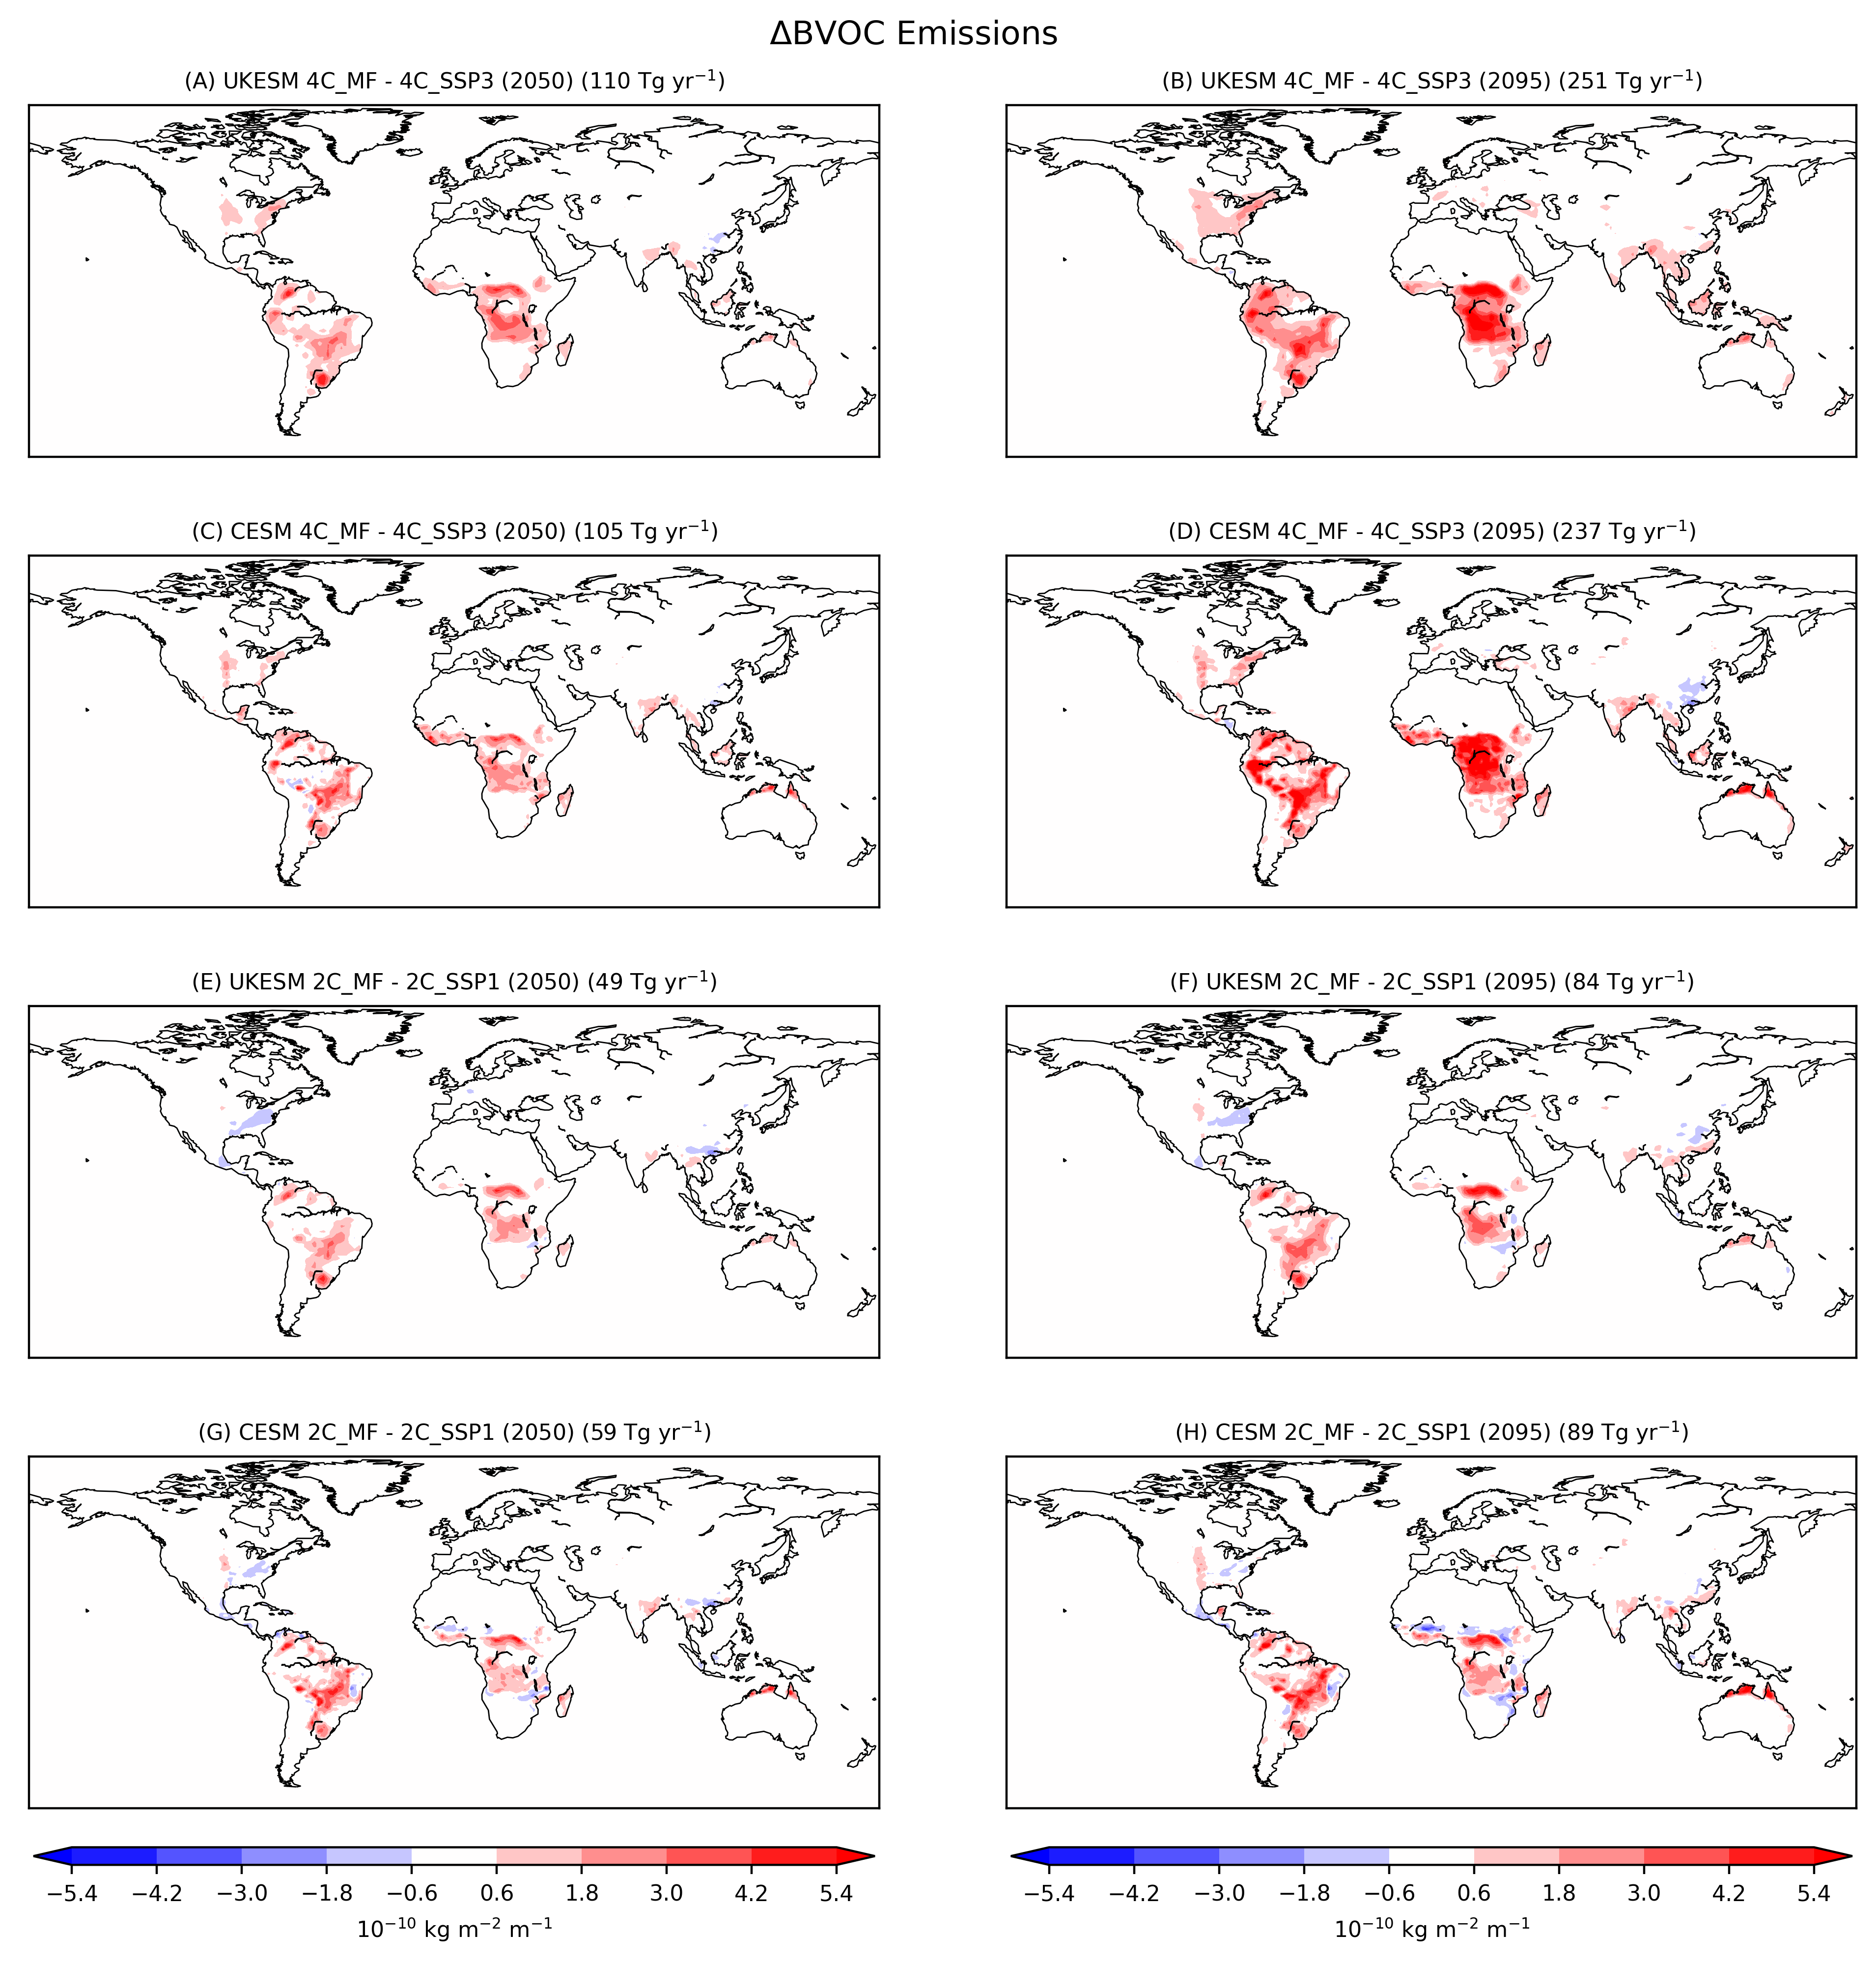

37376

In [13]:
min_lat = -64
max_lat = 85
scaling = 365 * 24 * 3600 / 1e9

contour_array_1 =  0.2*dan(np.arange(3,30,6))
extend_opt_1 = 'both'
cmap_opt_1 = 'bwr'
lat_1 = np.linspace(-90,90,192)
lon_1 = np.linspace(0,358.75,288)

lat_2=np.linspace(-89.375,89.375,144)
lon_2=np.linspace(0.9375,359.0625,192)
        
lon_1a,lat_1a=np.meshgrid(lon_1,lat_1)
lon_2a,lat_2a=np.meshgrid(lon_2,lat_2)
                      
fig, axes = plt.subplots(4, 2,#, shared='col',
figsize=(12,12), dpi=400)
plt.subplots_adjust(wspace=0.15, hspace=0.05)

#### 
map1=Basemap(ax=axes[0,0],llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=-180,urcrnrlon=180)
map1.drawcoastlines(linewidth=0.5)
x,y=map1(lon_2a,lat_2a)
p1=map1.contourf(x,y,ukesm_ssp370_2050* 1e10, contour_array_1,extend=extend_opt_1,latlon=True,cmap=cmap_opt_1)
axes[0,0].set_title( '(A) UKESM 4C_MF - 4C_SSP3 (2050) (%d Tg yr$^{-1}$)' %(np.sum(ukesm_ssp370_2050*area*scaling)), fontsize=8)

map2=Basemap(ax=axes[0,1],llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=-180,urcrnrlon=180)
map2.drawcoastlines(linewidth=0.5)
x,y=map2(lon_2a,lat_2a)
p2=map2.contourf(x,y,ukesm_ssp370_2095* 1e10, contour_array_1,extend=extend_opt_1,latlon=True,cmap=cmap_opt_1)
axes[0,1].set_title( '(B) UKESM 4C_MF - 4C_SSP3 (2095) (%d Tg yr$^{-1}$)' %(np.sum(ukesm_ssp370_2095*area*scaling)), fontsize=8)

#### 
map3=Basemap(ax=axes[1,0],llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=-180,urcrnrlon=180)
map3.drawcoastlines(linewidth=0.5)
x,y=map3(lon_1a,lat_1a)
p3=map3.contourf(x,y,cesm_ssp370_2050* 1e10, contour_array_1,extend=extend_opt_1,latlon=True,cmap=cmap_opt_1)
axes[1,0].set_title( '(C) CESM 4C_MF - 4C_SSP3 (2050) (%d Tg yr$^{-1}$)' %(np.sum(cesm_ssp370_2050*cesm_area*land_frac*scaling)), fontsize=8)

map4=Basemap(ax=axes[1,1],llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=-180,urcrnrlon=180)
map4.drawcoastlines(linewidth=0.5)
x,y=map4(lon_1a,lat_1a)
p4=map4.contourf(x,y,cesm_ssp370_2095* 1e10, contour_array_1,extend=extend_opt_1,latlon=True,cmap=cmap_opt_1)
axes[1,1].set_title( '(D) CESM 4C_MF - 4C_SSP3 (2095) (%d Tg yr$^{-1}$)' %(np.sum(cesm_ssp370_2095*cesm_area*land_frac*scaling)), fontsize=8)

#### 
map5=Basemap(ax=axes[2,0],llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=-180,urcrnrlon=180)
map5.drawcoastlines(linewidth=0.5)
x,y=map5(lon_2a,lat_2a)
p5=map5.contourf(x,y,ukesm_ssp126_2050* 1e10, contour_array_1,extend=extend_opt_1,latlon=True,cmap=cmap_opt_1)
axes[2,0].set_title( '(E) UKESM 2C_MF - 2C_SSP1 (2050) (%d Tg yr$^{-1}$)' %(np.sum(ukesm_ssp126_2050*area*scaling)), fontsize=8)

map6=Basemap(ax=axes[2,1],llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=-180,urcrnrlon=180)
map6.drawcoastlines(linewidth=0.5)
x,y=map6(lon_2a,lat_2a)
p6=map6.contourf(x,y,ukesm_ssp126_2095*1e10, contour_array_1,extend=extend_opt_1,latlon=True,cmap=cmap_opt_1)
axes[2,1].set_title( '(F) UKESM 2C_MF - 2C_SSP1 (2095) (%d Tg yr$^{-1}$)' %(np.sum(ukesm_ssp126_2095*area*scaling)), fontsize=8)

 
map7=Basemap(ax=axes[3,0],llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=-180,urcrnrlon=180)
map7.drawcoastlines(linewidth=0.5)
x,y=map7(lon_1a,lat_1a)
p7=map7.contourf(x,y,cesm_ssp126_2050*1e10, contour_array_1,extend=extend_opt_1,latlon=True,cmap=cmap_opt_1)
axes[3,0].set_title( '(G) CESM 2C_MF - 2C_SSP1 (2050) (%d Tg yr$^{-1}$)' %(np.sum(cesm_ssp126_2050*cesm_area*land_frac*scaling)), fontsize=8)

map8=Basemap(ax=axes[3,1],llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=-180,urcrnrlon=180)
map8.drawcoastlines(linewidth=0.5)
x,y=map8(lon_1a,lat_1a)
p8=map8.contourf(x,y,cesm_ssp126_2095 * 1e10, contour_array_1,extend=extend_opt_1,latlon=True,cmap=cmap_opt_1)
axes[3,1].set_title( '(H) CESM 2C_MF - 2C_SSP1 (2095) (%d Tg yr$^{-1}$)' %(np.sum(cesm_ssp126_2095*cesm_area*land_frac*scaling)), fontsize=8)


cax1 = inset_axes(axes[3,0],width="110%",height="5%",bbox_transform=axes[3,0].transAxes,bbox_to_anchor=(0.05,-0.20,0.9,1),loc= 'lower center')

cax2 = inset_axes(axes[3,1],width="110%",height="5%",bbox_transform=axes[3,1].transAxes,bbox_to_anchor=(0.05,-0.20,0.9,1),loc= 'lower center')

#cbaxes = fig.add_axes([0, 0,1, 1]) 
cb1=plt.colorbar(p7, cax1, ticks=contour_array_1, orientation='horizontal')
cb2=plt.colorbar(p8, cax2, ticks=contour_array_1, orientation='horizontal')
cb1.ax.tick_params(labelsize=8)
cb1.ax.set_xlabel('10$^{-10}$ kg m$^{-2}$ m$^{-1}$',size=8)
cb2.ax.tick_params(labelsize=8)
cb2.ax.set_xlabel('10$^{-10}$ kg m$^{-2}$ m$^{-1}$',size=8)

#plt.suptitle(main_title, y=title_loc)
plt.suptitle('$\Delta$BVOC Emissions', y=0.9)
plt.savefig('BVOC_emission_differences.PDF', dpi=300)
plt.show()
                      
import gc
gc.collect()